In [ ]:
'../../../data/food-101-resize_64/'

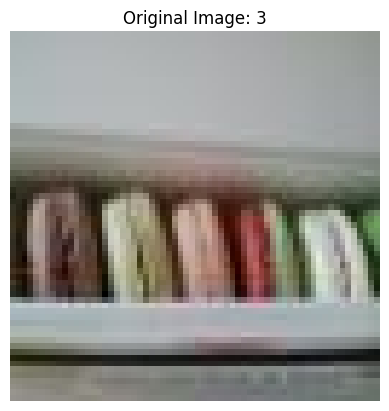

2024-06-28 15:16:53.743237: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/sequential_5_3/leaky_re_lu_17_1/LeakyRelu/LeakyReluGrad' exist for missing node 'sequential_5_3/conv2d_8_1/add'.
2024-06-28 15:19:08.427117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Generator Loss: 0.9869569540023804, Discriminator Loss: 1.4791183471679688


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input
from keras.preprocessing.image import load_img
from PIL import Image
from sklearn.model_selection import train_test_split

# Set latent space size
latent_space_size = 100

def get_random_input_vector(latent_space_size, batch_size=1):
    return np.random.rand(batch_size, latent_space_size)

def make_generator_model(latent_space_size):
    model = keras.Sequential()
    model.add(Input(shape=(latent_space_size,)))
    model.add(Dense(16 * 16 * 256, use_bias=False))  # Adjusted to match the final output size
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((16, 16, 256)))  # Adjusted to match the expected shape
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    return model

def load_data_food():
    folder_path = '../../../data/food-101-resize_64/'  # Update the path to your dataset
    size = 64
    images, labels, label_to_classname = [], [], {}
    for label, class_folder in enumerate(sorted(os.listdir(folder_path))):
        class_folder_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_folder_path):
            label_to_classname[label] = class_folder
            for filename in os.listdir(class_folder_path):
                file_path = os.path.join(class_folder_path, filename)
                if os.path.isfile(file_path):
                    try:
                        with Image.open(file_path) as img:
                            img = img.resize((size, size))
                            img_array = np.array(img)
                            images.append(img_array)
                            labels.append(label)
                    except Exception as e:
                        print(f'Error processing {filename}: {e}')
    images, labels = np.array(images), np.array(labels)
    X_train, y_train = images, labels
    return X_train, y_train, label_to_classname

def visualize_image(loc, X, y, title="Image"):
    image_array = X[loc].reshape(64, 64, 3)
    plt.imshow(image_array.astype(np.uint8))
    plt.title(f"{title}: {y[loc]}")
    plt.axis('off')
    plt.show()

X_train, y_train, label_to_classname = load_data_food()
visualize_image(3000, X_train, y_train, title="Original Image")

def make_discriminator_model():
    model = keras.Sequential()
    model.add(Input(shape=(64, 64, 3)))
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def create_batch_data(size=500, X=None, latent_space_size=latent_space_size):
    batch_real_images = X[:size]
    X = X[size:]
    random_vector = get_random_input_vector(latent_space_size, batch_size=size)
    batch_fake_images = generator.predict(random_vector)
    return np.concatenate([batch_real_images, batch_fake_images]), X

def prepare_dataset(X, batch_size):
    X = X / 255.0
    X = X.astype('float32')
    dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(60000).batch(batch_size, drop_remainder=True)
    return dataset

@tf.function
def train_step(real_images):
    noise = get_random_input_vector(latent_space_size, batch_size=real_images.shape[0])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

def train(dataset, epochs, save_dir, model_save_dir, loss_save_file):
    gen_losses, disc_losses = [], []
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, get_random_input_vector(latent_space_size), save_dir)
            generator.save(os.path.join(model_save_dir, f'generator_epoch_{epoch + 1:04d}_latent_space_size{latent_space_size}.h5'))
            discriminator.save(os.path.join(model_save_dir, f'discriminator_epoch_{epoch + 1:04d}_latent_space_size{latent_space_size}.h5'))
    generate_and_save_images(generator, epochs, get_random_input_vector(latent_space_size), save_dir)
    np.savez(loss_save_file, gen_losses=gen_losses, disc_losses=disc_losses)

def generate_and_save_images(model, epoch, test_input, save_dir):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, f'image_at_epoch_{epoch:04d}.png'))
    plt.show()

def plot_losses(loss_file):
    data = np.load(loss_file)
    gen_losses, disc_losses = data['gen_losses'], data['disc_losses']
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Loss During Training')
    plt.show()

def generate_images(generator_model, num_images, latent_space_size):
    random_vectors = get_random_input_vector(latent_space_size, batch_size=num_images)
    generated_images = generator_model(random_vectors, training=False)
    fig = plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :, :])
        plt.axis('off')
    plt.show()

# Main script execution
X_train, y_train, label_to_classname = load_data_food()
generator = make_generator_model(latent_space_size)
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator = make_discriminator_model()
batch_size = 256
food_dataset = prepare_dataset(X_train, batch_size)
epochs = 200
save_directory = 'training_images_' + str(epochs) + '_epochs_time_' + str(int(time.time()))
model_save_directory = 'saved_models'
loss_save_file = 'training_losses.npz'
if not os.path.exists(model_save_directory):
    os.makedirs(model_save_directory)
train(food_dataset, epochs, save_directory, model_save_directory, loss_save_file)
plot_losses(loss_save_file)
generator = keras.models.load_model(f'saved_models/generator_epoch_{epochs:04d}_latent_space_size{latent_space_size}.h5')
generate_images(generator, 16, latent_space_size)
